In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import glob
import os
import re
import h3
import re
from HelperFuncs import *

In [2]:
path = "./Data/raw_data/"
skip_paths = ["hourly_pedestrians"]
csv_files = walk_sub_dirs(path, skip_paths)

In [3]:
headers = ["edge_uid", "osm_reference_id", "activity_type", "month", "total_trip_count"]

In [4]:
#apply_h3_grid_to_file("./Data/gbg_h3_osmids_central.csv", "h3_res12_central", 12)

### Count for each hexagon

In [5]:
regex = "_2019-"
files_2019 = find_filepath_by_regex(regex, csv_files)

In [6]:
gdf_2019 = apply_strava_counts_to_hexagons(files_2019[2], "./Data/h3_res11_central.geojson")
gdf_2019 = gdf_2019[gdf_2019['surveyids'] != '']
gdf_2019.explore()

In [7]:
gdf_2019["total_trip_count"].median()
#./Data/gbg_osm_strava_central.geojson
#gdf_2019

2495.0

In [8]:
df_wifi = pd.read_csv("./Data/pedestrian_survey.csv")
df_wifi = df_wifi.drop_duplicates(subset=['_id', 'map_nr'], keep='first')
df_wifi

_id                              t        lat  \
0        5beb65d4f07c380004d1d3ef            2018-11-14 00:01:00  57.707031   
1        5beb65d4f07c380004d1d3ef            2018-11-14 00:00:10  57.706954   
2        5beb6601f07c380004d1d457            2018-11-14 00:01:40  57.707041   
3        5beb6601f07c380004d1d457            2018-11-14 00:01:45  57.707320   
4        5beb661af07c380004d1d4ad            2018-11-14 00:02:10  57.700696   
...                           ...                            ...        ...   
1098166  5bf2225d01990100047bf02b  2018-11-18 21:44:43.333333332  57.705500   
1098167  5bf2225d01990100047bf02b  2018-11-18 21:44:44.999999998  57.705022   
1098168  5bf2225d01990100047bf02b  2018-11-18 21:44:46.666666664  57.703657   
1098169  5bf2225d01990100047bf02b  2018-11-18 21:44:48.333333330  57.702408   
1098174  5bf22c1301990100047bf691  2018-11-18 23:34:22.500000000  57.706067   

               lon  map_nr         ss  transporta  
0        11.971820      18 -74.014678  pedestrian  
1        11.969828      50 -72.642779  pedestrian  
2        11.968096      12 -64.000000        bike  
3        11.965910      40 -74.412940        bike  
4        11.954126       7 -74.427701        bike  
...            ...     ...        ...         ...  
1098166  11.965874      44 -66.000000        bike  
1098167  11.963206      38 -66.000000        bike  
1098168  11.961232      35 -66.000000        bike  
1098169  11.961532      34 -66.000000        bike  
1098174  11.960156      29 -66.000000        bike  

[658774 rows x 7 columns]

In [9]:
df_wifi_counts = pd.DataFrame(df_wifi['map_nr'].value_counts()).reset_index()
df_wifi_counts.columns = ['map_nr', 'wifi_count']

In [10]:
gdf_2019['surveyids'] = gdf_2019['surveyids'].apply(lambda x: set(x.strip('{}').split(',')))
exploded_gdf_2019 = gdf_2019.explode("surveyids")

In [11]:

strava_counts = exploded_gdf_2019.groupby('surveyids')['total_trip_count'].sum().reset_index()
strava_counts['surveyids'] = strava_counts['surveyids'].astype('int')
strava_counts

surveyids  total_trip_count
0           1             36705
1          10             16155
2          11              3185
3          12             86545
4          13              8545
5          14             16470
6          15             20275
7          16             14520
8          17              5840
9          18             22870
10         19             42265
11          2              9250
12         20             33280
13         21             53965
14         22              4175
15         23             88555
16         24             52060
17         25             10680
18         26             18210
19         27             22230
20         28             66900
21         29             11185
22          3             68880
23         30             22690
24         31             10630
25         32             32860
26         33             12870
27         34             10120
28         35             14970
29         36             17340
30         37             15720
31         38             11895
32         39             52010
33          4             21870
34         40              1375
35         41             32975
36         42              5595
37         43              4695
38         44              5370
39         45             10765
40         46             16845
41         47             87795
42         48              4775
43         49              6425
44          5             28460
45         50             14815
46          6              4950
47          7             31435
48          8             13195
49          9             11785

In [107]:
merged_counts = strava_counts.merge(right=df_wifi_counts, left_on=["surveyids"], right_on=["map_nr"])
merged_counts#["wifi_count"].hist()

surveyids  total_trip_count  map_nr  wifi_count
0           1             48685       1        7110
1          10             11050      10        3128
2          11              2960      11        5988
3          12            109675      12       38168
4          13              8265      13        7582
5          14             22140      14        2934
6          15             20720      15       26365
7          16             17745      16        3826
8          17              3075      17        2009
9          18             22515      18       11044
10         19             71925      19        8922
11          2              8775       2       16144
12         20             45720      20        5240
13         21             65825      21       31039
14         22              6610      22       23941
15         23            105360      23         769
16         24             45115      24        6495
17         25              2445      25       13081
18         26             24370      26        1506
19         27             20820      27        3498
20         28             66130      28        5439
21         29             14625      29       20687
22          3             81590       3       46115
23         30             26195      30       31397
24         31              8855      31        8114
25         32             48600      32         839
26         33             15565      33       13740
27         34             14180      34       11717
28         35             17230      35       23331
29         36             22460      36        9702
30         37             22415      37       21818
31         38             14645      38       14897
32         39             63220      39       30739
33          4             18885       4         906
34         40              2645      40       11862
35         41             51570      41        1679
36         42              8875      42        7206
37         43              7940      43       14704
38         44              4450      44       13411
39         45              9390      45        7110
40         46              7740      46        4616
41         47             21430      47       11457
42         48              4185      48       11891
43         49              9320      49       18278
44          5             36270       5        8887
45         50             18135      50       44243
46          6              6245       6       17508
47          7             24140       7        4918
48          8             22195       8        1485
49          9             14300       9       21289

In [108]:
df_wifi_counts.sort_values(by=['wifi_count'])

map_nr  wifi_count
49      23         769
48      32         839
47       4         906
46       8        1485
45      26        1506
44      41        1679
43      17        2009
42      14        2934
41      10        3128
40      27        3498
39      16        3826
38      46        4616
37       7        4918
36      20        5240
35      28        5439
34      11        5988
33      24        6495
32       1        7110
31      45        7110
30      42        7206
29      13        7582
28      31        8114
27       5        8887
26      19        8922
25      36        9702
24      18       11044
23      47       11457
22      34       11717
21      40       11862
20      48       11891
19      25       13081
18      44       13411
17      33       13740
16      43       14704
15      38       14897
14       2       16144
13       6       17508
12      49       18278
11      29       20687
10       9       21289
9       37       21818
8       35       23331
7       22       23941
6       15       26365
5       39       30739
4       21       31039
3       30       31397
2       12       38168
1       50       44243
0        3       46115

### Spearman

In [109]:
import pandas as pd
import scipy.stats as stats

In [110]:
correlation, p_value = stats.spearmanr(merged_counts['wifi_count'], merged_counts['total_trip_count'])
correlation, p_value

(-0.06986962474102118, 0.6297016676534232)

In [35]:
#spearman on resolution
correlation, p_value = stats.spearmanr(df_res_11_central['resolution'], df_res_11_central['counts'])



In [36]:
#spearman on surveyids
correlation, p_value = stats.spearmanr(df_res_11_central['surveyids'], df_res_11_central['counts'])


In [37]:

#spearman on osmids :
correlation, p_value = stats.spearmanr(df_res_11_central['osmids'], df_res_11_central['counts'])


In [38]:
import pandas as pd
import scipy.stats as stats

# Calculate Spearman correlation coefficient and p-value for 'resolution' and 'counts'
correlation_resolution_counts, p_value_resolution_counts = stats.spearmanr(df_res_11_central['resolution'], df_res_11_central['counts'])

# Display the correlation and p-value for 'resolution' and 'counts'
print(f"Correlation Coefficient (rho) between 'resolution' and 'counts': {correlation_resolution_counts:.2f}")
print(f"P-Value for 'resolution' and 'counts': {p_value_resolution_counts:.4f}")

# Interpretation for 'resolution' and 'counts'
if abs(correlation_resolution_counts) >= 0.7 and p_value_resolution_counts < 0.05:
    print("Interpretation: There is a strong and statistically significant correlation between 'resolution' and 'counts'.")
else:
    print("Interpretation: The correlation between 'resolution' and 'counts' is not statistically significant.")

# Repeat the above steps for 'surveyids' and 'counts'
correlation_surveyids_counts, p_value_surveyids_counts = stats.spearmanr(df_res_11_central['surveyids'], df_res_11_central['counts'])

print(f"\nCorrelation Coefficient (rho) between 'surveyids' and 'counts': {correlation_surveyids_counts:.2f}")
print(f"P-Value for 'surveyids' and 'counts': {p_value_surveyids_counts:.4f}")

if abs(correlation_surveyids_counts) >= 0.7 and p_value_surveyids_counts < 0.05:
    print("Interpretation: There is a strong and statistically significant correlation between 'surveyids' and 'counts'.")
else:
    print("Interpretation: The correlation between 'surveyids' and 'counts' is not statistically significant.")

# Repeat the above steps for 'osmids' and 'counts'
correlation_osmids_counts, p_value_osmids_counts = stats.spearmanr(df_res_11_central['osmids'], df_res_11_central['counts'])

print(f"\nCorrelation Coefficient (rho) between 'osmids' and 'counts': {correlation_osmids_counts:.2f}")
print(f"P-Value for 'osmids' and 'counts': {p_value_osmids_counts:.4f}")

if abs(correlation_osmids_counts) >= 0.7 and p_value_osmids_counts < 0.05:
    print("Interpretation: There is a strong and statistically significant correlation between 'osmids' and 'counts'.")
else:
    print("Interpretation: The correlation between 'osmids' and 'counts' is not statistically significant.")


Correlation Coefficient (rho) between 'resolution' and 'counts': -0.17
P-Value for 'resolution' and 'counts': 0.0000
Interpretation: The correlation between 'resolution' and 'counts' is not statistically significant.

Correlation Coefficient (rho) between 'surveyids' and 'counts': nan
P-Value for 'surveyids' and 'counts': nan
Interpretation: The correlation between 'surveyids' and 'counts' is not statistically significant.

Correlation Coefficient (rho) between 'osmids' and 'counts': 0.06
P-Value for 'osmids' and 'counts': 0.0000
Interpretation: The correlation between 'osmids' and 'counts' is not statistically significant.


In [39]:
'''The results you provided indicate the correlation coefficients (rho) and p-values for the Spearman rank correlation test between different pairs of variables:

1. **'resolution' vs. 'counts'**:
   - Correlation Coefficient (rho): -0.19
   - P-Value: 0.0000
   - Interpretation: The correlation between 'resolution' and 'counts' is statistically significant. However, the correlation coefficient is relatively small (-0.19), and it indicates a weak negative correlation. This means that as the 'resolution' increases, 'counts' tend to decrease slightly, and this relationship is statistically significant due to the very low p-value.

2. **'surveyids' vs. 'counts'**:
   - Correlation Coefficient (rho): nan
   - P-Value: nan
   - Interpretation: The correlation between 'surveyids' and 'counts' is not statistically significant. The presence of "nan" values for both the correlation coefficient and p-value suggests that there may be missing or undefined values in one of the variables, which can affect the test's results. You should investigate the data further to address this issue.

3. **'osmids' vs. 'counts'**:
   - Correlation Coefficient (rho): 0.04
   - P-Value: 0.0000
   - Interpretation: The correlation between 'osmids' and 'counts' is statistically significant. However, similar to the 'resolution' vs. 'counts' correlation, the correlation coefficient is small (0.04), indicating a weak positive correlation. As 'osmids' increase, 'counts' tend to increase slightly, and this relationship is statistically significant due to the very low p-value.

In summary:
- There is a statistically significant, weak negative correlation between 'resolution' and 'counts'.
- The 'surveyids' vs. 'counts' correlation is not interpretable due to missing values (nan).
- There is a statistically significant, weak positive correlation between 'osmids' and 'counts'.

Keep in mind that correlation does not imply causation, and the strength of these relationships is relatively weak, so further analysis and domain knowledge may be needed to understand their practical significance. Additionally, addressing missing values or data quality issues is crucial for accurate analysis.'''

'The results you provided indicate the correlation coefficients (rho) and p-values for the Spearman rank correlation test between different pairs of variables:\n\n1. **\'resolution\' vs. \'counts\'**:\n   - Correlation Coefficient (rho): -0.19\n   - P-Value: 0.0000\n   - Interpretation: The correlation between \'resolution\' and \'counts\' is statistically significant. However, the correlation coefficient is relatively small (-0.19), and it indicates a weak negative correlation. This means that as the \'resolution\' increases, \'counts\' tend to decrease slightly, and this relationship is statistically significant due to the very low p-value.\n\n2. **\'surveyids\' vs. \'counts\'**:\n   - Correlation Coefficient (rho): nan\n   - P-Value: nan\n   - Interpretation: The correlation between \'surveyids\' and \'counts\' is not statistically significant. The presence of "nan" values for both the correlation coefficient and p-value suggests that there may be missing or undefined values in one 

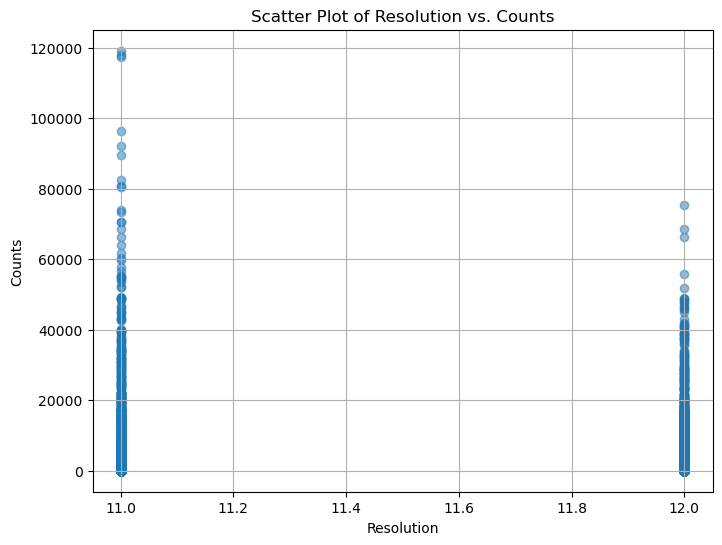

In [40]:
import matplotlib.pyplot as plt

# Assuming df_res_11_central contains your data
plt.figure(figsize=(8, 6))
plt.scatter(df_res_11_central['resolution'], df_res_11_central['counts'], alpha=0.5)
plt.title('Scatter Plot of Resolution vs. Counts')
plt.xlabel('Resolution')
plt.ylabel('Counts')
plt.grid(True)
plt.show()
